# Imports

In [21]:
import pandas as pd
import numpy as np
import regex as re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
#from spacy.tokenizer import Tokenizer
from tqdm import tqdm
import contractions
import string
from nltk.tokenize import word_tokenize # must use this for collocations, spacy tokeniser seems incompatible when calcualting pmi score
from unidecode import unidecode
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv('./data/covid19_articles_20201231.csv')

# Date to datetime
df['date'] = pd.to_datetime(df['date'])

print(df.info())
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369047 entries, 0 to 369046
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   author      181799 non-null  object        
 1   date        369047 non-null  datetime64[ns]
 2   domain      369047 non-null  object        
 3   title       368962 non-null  object        
 4   url         369047 non-null  object        
 5   content     369047 non-null  object        
 6   topic_area  369047 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 19.7+ MB
None


,author,date,domain,title,url,content,topic_area
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business
1,Thomas Hughes,2020-01-03,marketbeat,Labor Stocks Are Going To Break Out In 2020,https://www.marketbeat.com/originals/labor-sto...,The labor markets were one of the most closely...,business
2,Steve Anderson,2020-01-03,marketbeat,"Tesla (TSLA) Breaks Shipment Record, Beats Est...",https://www.marketbeat.com/originals/teal-brea...,"It could be forgiven, that some might think th...",business


# Drop Article Functions
* Drop duplicates
* Drop short and long articles
* Drop articles that are annual reports or conversation transcripts
* Drop long and blank titles

In [4]:
def drop_articles(df):
    
    df = df.copy()
    
    # Drop duplicates
    num_articles_pre_drop = len(df)
    df = df.drop_duplicates(subset='content')
    print(f'no. articles dropped: {num_articles_pre_drop - len(df)} duplicates')
    
    # Drop long articles
    num_articles_pre_drop = len(df)
    df = df[df['content'].str.len() < 50000]
    print(f'no. articles dropped: {num_articles_pre_drop - len(df)} long articles')
    
    # Drop short articles
    num_articles_pre_drop = len(df)
    df = df[df['content'].str.len() > 100]
    print(f'no. articles dropped: {num_articles_pre_drop - len(df)} short articles')
    
    # Drop articles with annual report as title
    num_articles_pre_drop = len(df)
    df = df[~df['title'].str.contains("Annual Report | Half-yearly financial report | half-year report", na=False)]
    print(f'no. articles dropped: {num_articles_pre_drop - len(df)} annual reports')
    
    # Drop earnings conference call transcripts
    num_articles_pre_drop = len(df)
    df = df[~df['title'].str.contains("earnings conference call | transcript", na=False)]
    print(f'no. articles dropped: {num_articles_pre_drop - len(df)} earnings call transcripts')
    
    # Drop articles without titles
    num_articles_pre_drop = len(df)
    df = df[~pd.isna(df['title'])]
    print(f'no. articles dropped: {num_articles_pre_drop - len(df)} articles without titles')
    
    # Drop long article titles
    num_articles_pre_drop = len(df)
    df = df[df['title'].apply(lambda x: len(x.split())) < 512]
    print(f'no. articles dropped: {num_articles_pre_drop - len(df)} articles with long titles')
    
    print('no. of articles: ', len(df))
    
    return df

In [5]:
test = drop_articles(df)

no. articles dropped: 127 duplicates
no. articles dropped: 3095 long articles
no. articles dropped: 92 short articles
no. articles dropped: 139 annual reports
no. articles dropped: 477 earnings call transcripts
no. articles dropped: 85 articles without titles
no. articles dropped: 1 articles with long titles
no. of articles:  365031


# Cleaning Functions

* Remove most non word characters
* Remove emails, tags, websites
* Remove most numbers
* Expand contractions
* Remove long words that are most likely not english or are references
* Remove stopwords
* Lowercase text

In [6]:
def strip_text(text):
    """
    :remove new line and trailing leading whitespace
    """
    text = text.strip()
    text = text.replace('\n',' ')

    return text

def is_number(text):
    """
    :utility function to test if text is a number
    """
    try:
        float(text) if '.' in text else int(text)
        return True
    except ValueError:
        return False

def remove_numbers(text):
    """
    :remove numbers, percentages, dollar values
    """
    
    regex_percent = re.compile(r'[\-\+]?[\d]+\.?\d*[%]+\.?') # e.g. 3%, -3.8%
    regex_number_fullstop = re.compile(r'\d+[\.]') # e.g. 2019.
    regex_number_fullstop_2 = re.compile(r'\d+\.\d+\.') # e.g. 2019.28.
    regex_dollar_number = re.compile(r'[\$]+[\d,]+\.?\d*') # e.g. $2 or $2.4567
    regex_thousands = re.compile(r'\d+\,\d+') # e.g. 4,000 or 4,000.00
    regex_thousands_2 = re.compile(r'\d+\,\d+\W') # e.g. 4,000 or 4,000.00
    
    percent = regex_percent.findall(text)
    number_fullstop = regex_number_fullstop.findall(text)
    number_fullstop_2 = regex_number_fullstop_2.findall(text)
    dollar_number = regex_dollar_number.findall(text)
    thousands = regex_thousands.findall(text)
    thousands_2 = regex_thousands_2.findall(text)

    word_removals = percent + number_fullstop + number_fullstop_2 + dollar_number + thousands + thousands_2

    tokens = text.split(" ")
    
    # remove integers and floats
    tokens_filtered = [word for word in tokens if not is_number(word)]
    # remove percentages
    tokens_filtered = [word for word in tokens_filtered if word not in word_removals]
    
    text_clean = (" ").join(tokens_filtered)
    
    return text_clean

def remove_emails_tags_websites(text):
    """
    : remove emails and tags (e.g @sleepingbeauty)
    """
    # Add a space before commas to seperate from preceeding word
    text = re.sub(",", " ,", text)
    
    regex_email = re.compile(r'[\w\.-]+@[\w\.-]+.') # email with character at end, e.g. space
    regex_email2 = re.compile(r'[\w\.-]+@[\w\.-]+') # email with no character at end
    regex_tag = re.compile(r'@[\w\.-]+') # tags e.g @sleepingbeauty
    regex_tag2 = re.compile(r'\S+@[\w\.-]+.') # tags plus character e.g (@sleepingbeauty)
    regex_web = re.compile(r'\b\w*http\w*\b') # string containing 'http'
    regex_web2 = re.compile(r'[\w\.]*www[\w\.]*') # string containing 'www'
    
    email = regex_email.findall(text)
    email2 = regex_email2.findall(text)
    tag = regex_tag.findall(text)
    tag2 = regex_tag2.findall(text)
    web = regex_web.findall(text)
    web2 = regex_web2.findall(text)
    
    word_removals = email + email2 + tag + tag2 + web + web2
    
    tokens = text.split(" ")
    tokens_filtered = [word for word in tokens if word not in word_removals]
    text_clean = (" ").join(tokens_filtered)
    
    return text_clean

def remove_contraction_possesive_apostrophes(text):
    """
    :remove contraction e.g. can't, won't, she'll -> cant, and possesive apostrophes +s e.g The president's dog -> president
    note: not completely correct as removes 's from e.g. that's which is a contraction rather that possessive, but this is not seen as an issue
    """
    
    #regex_contraction = re.compile(r"[a-zA-Z]+'[a-rt-zA-RT-Z]+|[a-zA-Z]+’[a-rt-zA-RT-Z]+")
    #contraction = regex_contraction.findall(text)
    
    regex_possessive = re.compile(r"[a-zA-Z]+'[sS]+|[a-zA-Z]+’[sS]+")
    possessive = regex_possessive.findall(text)
    
    tokens = text.split(" ")
    
    # remove contractions
    #tokens_filtered = [word if word not in contraction else word.replace("'", "").replace("’","") for word in tokens]
    # replace 's
    tokens_filtered = [word if word not in possessive else word.replace("'s", "").replace("’s","").replace("'S","").replace("’S","") for word in tokens]
    
    text_clean = (" ").join(tokens_filtered)
    
    return text_clean

def expand_contractions(text):
    
    try:
        expanded_text = contractions.fix(text)
    except:
        expanded_text = text
        
    return expanded_text

def remove_punctuation(text):
    """
    :remove english punctuation (note: does not remove non english punctuation, e.g german version of ")
    """
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_long_words(text):
    """
    :remove words that are likely not english or html references
    """
    tokens = text.split(" ")
    tokens_filtered = [word for word in tokens if len(word) < 20 ]
    text_clean = (" ").join(tokens_filtered)
    
    return text_clean

def lowercase_text(text):
    """
    :convert text to lowercase
    """
    return text.lower()

def remove_stopwords(text):
    """
    :remove stopwords
    """
    stop_word_list = spacy.lang.en.stop_words.STOP_WORDS
    tokens = text.split(" ")
    tokens_filtered = [word for word in tokens if word not in stop_word_list]
    tokens_filtered = [word for word in tokens_filtered if word != " "]
    tokens_filtered = [word for word in tokens_filtered if word != ""]
    # Remove single char words
    tokens_filtered = [word for word in tokens_filtered if len(word) > 1]
    text_clean = (" ").join(tokens_filtered)
    return text_clean
    
def remove_accents_non_english_char(text):
    """
    :remove accents and non english characters (includes non english punctuation)
    """
    #text = unidecode(text, "utf-8")
    text = unidecode(text)
    text = text.replace('\n',' ')

    return text
    

In [7]:
# Example text before cleaning
df['content'][2]

'It could be forgiven, that some might think that Tesla (NASDAQ: TSLA) was little more than a big pile of pie-in-the-sky nonsense. Yet it seems, these days, that we hear a lot of positive buzz around this maker of electric vehicles that implores we take this company seriously. One more brick in the wall of credibility has fallen into place, as recently, Tesla reported its delivery and production numbers for the fourth quarter of 2019. The news is shockingly good, as evidenced by key phrases like “record-breaking.” Production Is Off and Running The key number for the fourth quarter at Tesla was 112,000, which is how many vehicles were delivered worldwide for the period. This not only beat Wall Street estimates by 6,000 vehicles—estimates said 106,000 would go out the door—but it also beat a goal set up by Musk earlier in the year. Interestingly, if Tesla had matched the street estimates, it still would have met Musk\'s own goal, so it\'s a surprise for both entities. Tesla noted that, i

In [8]:
# Example text after cleaning
test = strip_text(df['content'][2])
test = remove_numbers(test)
test = expand_contractions(test)
test = remove_contraction_possesive_apostrophes(test)
test = remove_accents_non_english_char(test)
test = remove_punctuation(test)
test = remove_emails_tags_websites(test)
test = remove_numbers(test)
test = remove_long_words(test)
test = lowercase_text(test)
print(test)

it could be forgiven that some might think that tesla nasdaq tsla was little more than a big pile of pieinthesky nonsense yet it seems these days that we hear a lot of positive buzz around this maker of electric vehicles that implores we take this company seriously one more brick in the wall of credibility has fallen into place as recently tesla reported its delivery and production numbers for the fourth quarter of the news is shockingly good as evidenced by key phrases like recordbreaking production is off and running the key number for the fourth quarter at tesla was which is how many vehicles were delivered worldwide for the period this not only beat wall street estimates by vehiclesestimates said would go out the doorbut it also beat a goal set up by musk earlier in the year interestingly if tesla had matched the street estimates it still would have met musk own goal so it is a surprise for both entities tesla noted that in it delivered a grand total of around vehicles a move which

In [9]:
test = remove_stopwords(test)
test

'forgiven think tesla nasdaq tsla little big pile pieinthesky nonsense days hear lot positive buzz maker electric vehicles implores company seriously brick wall credibility fallen place recently tesla reported delivery production numbers fourth quarter news shockingly good evidenced key phrases like recordbreaking production running key number fourth quarter tesla vehicles delivered worldwide period beat wall street estimates vehiclesestimates said doorbut beat goal set musk earlier year interestingly tesla matched street estimates met musk goal surprise entities tesla noted delivered grand total vehicles represents increase 2018s figures good news stretch sufficient drive percent price increase increase overall year given gains writing handily yesterday close watched pot boiling pretty hard surprising tesla delivery figures watched closely considered best way figure tesla sales numberswhich reasonable obviously selling vehicles delivering unexpected cancellations asideand numbers spot

# Combined Function

In [10]:
def data_preprocessing(df):
    df = df.copy()
    df['content_processed'] = ''
    col_index = df.columns.get_loc('content_processed')
        
    for idx, content in tqdm(enumerate(df['content'])):

        text = strip_text(content)
        text = remove_numbers(text)
        text = expand_contractions(text)
        text = remove_contraction_possesive_apostrophes(text)
        text = remove_accents_non_english_char(text)
        text = remove_punctuation(text)
        text = remove_emails_tags_websites(text)
        text = remove_numbers(text)
        text = remove_long_words(text)
        text = lowercase_text(text)
        text = remove_stopwords(text)

        df.iat[idx, col_index] = text
        #if idx % 50000 == 0:
         #   print(f'{idx} records processed')
    
    return df
    

## Complete Preprocessing - Step 1 - Cleaning

In [11]:
complete_preprocessing = False

if complete_preprocessing:
    # ~ 30 mins to run
    df_processed = drop_articles(df)
    df_processed = data_preprocessing(df_processed)
    df_processed.to_pickle('./data/df_processed.pickle')
else:
    df_processed = pd.read_pickle('./data/df_processed.pickle')

In [12]:
print(len(df_processed))
df_processed.head(1).append(df_processed.tail(1))

365031


,author,date,domain,title,url,content,topic_area,content_processed
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...
369046,NaN,2020-12-31,marketscreener,FTSE 100 wraps up worst year since 2008 financ...,https://www.marketscreener.com/quote/index/FTS...,"The FTSE 100 lost 1.5%, with consumer stocks, ...",business,ftse lost consumer stocks mainly unilever diag...


In [13]:
df_processed['content_processed'][8106]

'ann friend mentor 50s exclaimed coffee end january know amazon sold medical masks going upstate weekend better luck looked quizzically time world health organization announced newly named disease covid19 known 2019ncov caused virus sarscov2 simply coronavirus public health emergency international concern pheic announcement delayed days masks reserved people symptoms ann intellectual easily head panic mode helped law career immensely later ceo business leader moment mind masks prudent thing purchase despite lack indication needed effectively ann hedging idea messages received media friends better conservative overly prepared worst given potential consequences underprepared immediately struck despite trained epidemiology medicine entirely sure advise ann time messages received articles read consistent uncertainty coronavirus terms projected ordinary citizens minimize risk decisions day despite uncertainty emotions come play things trickier comes public health risks sending wrong message

# Colocations

Process:
* find collocations
* determine cutoff (at least 50 times present, top 1000 bigrams?)
* search all text and combine bigrams into one word with _ seperator e.g. supply_chain

TO DO
* When converting bigrams, convert highest ranking bigrams first, e.g. a problem is president_donald and donald_trump are both found colocations, but my converting process takes the first words found and so while donald_trump is a better bigram, president_donald is the one that is formed

In [14]:
import nltk
#nltk.download('punkt')
from nltk.collocations import *
from nltk.tokenize import word_tokenize

In [35]:
def tokenise_dataframe(df):

    df = df.copy()
    df['tokens'] = ""
    col_index = df.columns.get_loc("tokens")
    
    for idx, article in enumerate(df['content_processed']):
        tokens = word_tokenize(article)
        df.iat[idx, col_index] = list(tokens)
    
    return df
    
def find_colocations(tokens, min_freq=1000, n_bigrams=2500):
    """
    min_freq: minimum number of occurances to be included
    n_bigrans: number of bigrams to return (rated from highest scored using pmi measure)
    """
    
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    #trigram_measures = nltk.collocations.TrigramAssocMeasures()

    finder_bigram = BigramCollocationFinder.from_documents(tokens)
    #finder_trigram = TrigramCollocationFinder.from_documents(tokens)
    
    finder_bigram.apply_freq_filter(min_freq)
    scores = finder_bigram.score_ngrams(bigram_measures.pmi)
    bigrams = finder_bigram.nbest(bigram_measures.pmi, n_bigrams)
    df_bigrams_freq = pd.DataFrame(finder_bigram.ngram_fd.items(), columns=['bigram', 'freq'])
    df_bigrams_freq['pmi_score'] = df_bigrams_freq['bigram'].apply(lambda x: [score[1] for score in scores if score[0] == x][0])

    return bigrams, df_bigrams_freq

In [36]:
# takes ~15 minutes
test_token = tokenise_dataframe(df_processed)
test_bigrams, test_df_bigrams_freq = find_colocations(test_token['tokens'])

In [32]:
test_df_bigrams_freq = test_df_bigrams_freq.sort_values('pmi_score', ascending=False).reset_index(drop=True)
word_check = 'drug'
test_df_bigrams_freq_word = test_df_bigrams_freq[test_df_bigrams_freq['bigram'].str[0].str.contains(word_check)].append(test_df_bigrams_freq[test_df_bigrams_freq['bigram'].str[1].str.contains(word_check)])
test_df_bigrams_freq_word.index = test_df_bigrams_freq_word.index.rename('rank')
test_df_bigrams_freq_word

,bigram,freq,pmi_score
rank,,,
1775,"(drug, administration)",10056,8.672796
2010,"(drug, discovery)",1143,8.338015
2377,"(drug, candidates)",2468,7.878256
4382,"(drug, application)",1001,5.909215
4811,"(drug, development)",2145,5.512653
771,"(orphan, drug)",1219,10.637076
1403,"(antiviral, drug)",1140,9.256839
2066,"(food, drug)",10208,8.272951
7096,"(new, drug)",2286,3.250518


In [18]:
def create_bigrams_article(text, bigrams):
    """
    :convert bigrams to one word for an individual article
    used within create_bigrams function
    this method does not allow for priority of bigram, i.e. mr_donald will be made and donald_trump will not
    """

    tokens = text.split(" ")
    tokens_with_bigrams = []
    idx = 0
    while idx < len(tokens) -1:
        if (tokens[idx], tokens[idx+1]) in bigrams:
            bigram = str(tokens[idx]) + '_' + str(tokens[idx+1])
            tokens_with_bigrams.append(bigram)
            idx += 2
        else:
            tokens_with_bigrams.append(tokens[idx])
            idx += 1
    if (tokens[-2], tokens[-1]) not in bigrams:
        tokens_with_bigrams.append(tokens[-1])

    text_clean = (" ").join(tokens_with_bigrams)
    
    return text_clean

def create_bigrams_article_v2(text, bigrams):
    """
    :convert bigrams to one word for an individual article
    used within create_bigrams function
    this method will create full connections bigger than bigrams, i.e. mr_donald_trump
    """

    for bigram in bigrams:
        bigram_str = bigram[0] + ' ' + bigram[1]
        bigram_str_sub = bigram[0] + '_' + bigram[1]
        text = re.sub(bigram_str, bigram_str_sub, text)
    
    return text
        
def create_bigrams(df, min_freq=1000, n_bigrams=2500):
    """
    :convert bigrams to one word for entire df
    """
    
    df = df.copy()
    col_index = df.columns.get_loc('content_processed')
    
    df_tokenised = tokenise_dataframe(df)
    print('df tokenised')
    tokens = df_tokenised['tokens']
    
    bigrams, df_bigrams_freq = find_colocations(tokens, min_freq, n_bigrams)
    print('bigrams found')
            
    for idx, content in tqdm(enumerate(df['content_processed'])):
        text = create_bigrams_article_v2(content, bigrams)
        df.iat[idx, col_index] = text
        #if idx % 50000 == 0:
         #   print(f'{idx} records processed')
            
    return bigrams, df, df_bigrams_freq

## Complete Preprocessing - Step 2 - Colocations

In [19]:
# Can also be run using 01_data_preprocessing.py
complete_preprocessing = False

if complete_preprocessing:
    # method 1 ~ 2.5 hours to run
    # method 2 ~ 12 hours to run
    df_processed = pd.read_pickle('./data/df_processed.pickle')
    bigrams, df_processed_bigrams, df_bigrams_freq = create_bigrams(df_processed)
    df_processed_bigrams.to_pickle('./data/df_processed_bigrams.pickle')
    
    df_bigrams = pd.DataFrame(bigrams, columns=['bigram_w1', 'bigram_w2'])
    df_bigrams['freq'] = ''
    for idx in range(len(df_bigrams)):
        bigram_check = (df_bigrams['bigram_w1'][idx], df_bigrams['bigram_w2'][idx])
        freq = df_bigrams_freq[df_bigrams_freq['bigram'] == bigram_check]['freq'].values[0]
        df_bigrams.loc[idx, 'freq'] = freq
    df_bigrams.to_csv('./data/bigrams/bigrams.csv', index=False)
    df_bigrams_freq.to_csv('./data/bigrams/df_bigrams_freq.csv', index=False)
    
else:
    df_processed_bigrams = pd.read_pickle('./data/df_processed_bigrams.pickle')
    df_bigrams = pd.read_csv('./data/bigrams/bigrams.csv')
    df_bigrams_freq = pd.read_csv('./data/bigrams/df_bigrams_freq.csv')

#### Analysis of bigrams to decide cut-off points

In [37]:
# Takes ~3 hours
test_bigrams, test_df_bigrams_freq = find_colocations(test_token['tokens'], min_freq=100, n_bigrams=5000)
test_df_bigrams_freq.to_csv('./data/bigrams/test_df_bigrams_freq_freq100_n5000.csv')

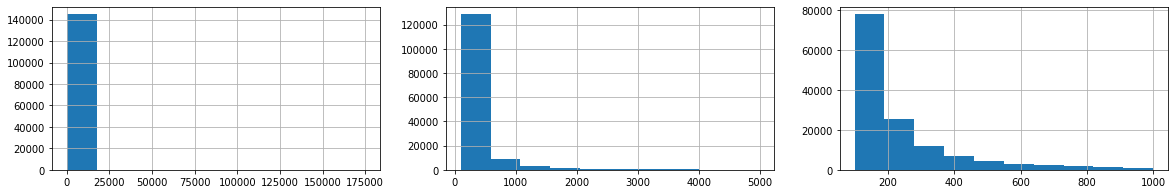

In [43]:
# Histogram of bigram frequency

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,3))
test_df_bigrams_freq['freq'].hist(ax=ax1)
test_df_bigrams_freq[test_df_bigrams_freq['freq'] < 5000]['freq'].hist(ax=ax2)
test_df_bigrams_freq[test_df_bigrams_freq['freq'] < 1000]['freq'].hist(ax=ax3)

plt.show()

In [45]:
test_df_bigrams_freq.sort_values('pmi_score')

,bigram,freq,pmi_score
64620,"(said, income)",110,-4.112481
126300,"(financial, company)",105,-4.047505
24432,"(global, said)",126,-3.960054
18489,"(million, said)",358,-3.870581
41562,"(coronavirus, million)",185,-3.837217
...,...,...,...
51981,"(sankalp, phartiyal)",105,20.403249
55912,"(mfuneko, toyana)",107,20.403249
41514,"(caseythevergecom, zoethevergecom)",108,20.403249
8688,"(mauroorruwsjcom, mauroorru94)",103,20.443142


In [56]:
test_df_bigrams_freq[test_df_bigrams_freq['freq'] < 1000].sort_values('freq', ascending=False)[:20]

,bigram,freq,pmi_score
2467,"(treating, patients)",999,7.125151
22479,"(steroid, dexamethasone)",999,14.738560
25357,"(help, stop)",999,4.428522
54113,"(trump, supporters)",999,5.939000
42654,"(news, press)",999,3.225871
42954,"(yearoveryear, growth)",999,6.021829
4457,"(revenue, company)",999,0.363816
35421,"(months, company)",999,-0.179576
48052,"(new, law)",999,1.865743
70508,"(deferred, financing)",999,7.656390


In [58]:
test_df_bigrams_freq[test_df_bigrams_freq['freq'] >= 1000].sort_values('freq')[:20]

,bigram,freq,pmi_score
43004,"(markets, led)",1000,4.425578
2535,"(said, seeing)",1000,1.911875
5438,"(assumptions, including)",1000,3.583832
12150,"(settle, barrel)",1000,10.922341
4320,"(domestic, demand)",1000,4.637179
6816,"(deaths, people)",1000,1.631839
29061,"(gold, mining)",1000,6.596807
42971,"(corporate, finance)",1000,5.901256
67597,"(conference, information)",1000,3.077321
143304,"(percentage, regioncountry)",1000,7.225251


#### Overview of bigrams created

In [32]:
# Snapshot of bigrams captured
df_bigrams_freq[df_bigrams_freq['freq'] < 50000]

,bigram,freq
0,"(end, year)",13063
1,"(time, think)",1302
2,"(market, leader)",1328
3,"(energy, sector)",1788
4,"(expected, grow)",2723
...,...,...
8615,"(15year, perspective)",2571
8616,"(presidentelect, joe)",1878
8617,"(content, december)",1172
8618,"(unaltered, december)",1232


In [33]:
df_bigrams_freq[df_bigrams_freq['bigram'] == ('supply', 'chains')]

,bigram,freq
137,"(supply, chains)",9493


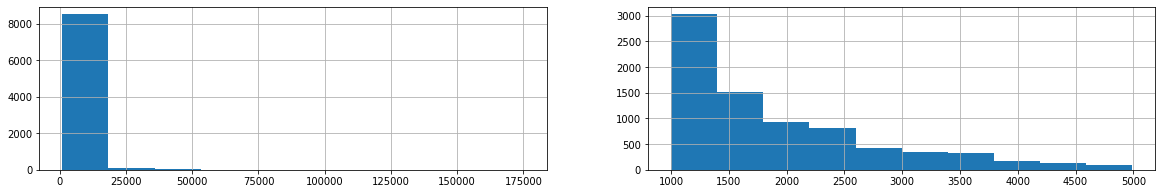

In [24]:
# Histogram of bigram frequency

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,3))
df_bigrams_freq['freq'].hist(ax=ax1)
df_bigrams_freq[df_bigrams_freq['freq'] < 5000]['freq'].hist(ax=ax2)
plt.show()

In [35]:
print(len(df_processed_bigrams))
df_processed_bigrams.head(1).append(df_processed_bigrams.tail(1))

365200


,author,date,domain,title,url,content,topic_area,content_processed
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...
369046,NaN,2020-12-31,marketscreener,FTSE 100 wraps up worst year since 2008 financ...,https://www.marketscreener.com/quote/index/FTS...,"The FTSE 100 lost 1.5%, with consumer stocks, ...",business,ftse lost consumer stocks mainly unilever diag...


In [36]:
df_processed_bigrams[df_processed_bigrams['content_processed'].str.contains("supply_chains")]

,author,date,domain,title,url,content,topic_area,content_processed
4,Alden Wicker,2020-01-06,instyle,Red Carpet Sustainability After Coronavirus Sh...,https://www.instyle.com/fashion/red-carpet-cor...,When the coronavirus pandemic is over and life...,consumer,coronavirus pandemic life returns normal celeb...
13,Thomas Hughes,2020-01-08,marketbeat,"Constellation Brands Star Is Rising, Revenue A...",https://www.marketbeat.com/originals/constelll...,The analysts turned cautious on Constellation ...,business,analysts turned cautious constellation brands ...
21,Thomas Hughes,2020-01-09,marketbeat,"Tesla Bull Says Its Time To Take Profits, Tesl...",https://www.marketbeat.com/originals/tesla-bul...,Analysts at Argus think the stock could go to ...,business,analysts argus think stock months set wall_str...
161,Chris Markoch,2020-01-21,marketbeat,Why Bad News May be Good News for Boeing,https://www.marketbeat.com/originals/why-bad-n...,There is a saying that bad news comes in three...,business,saying bad news comes threes case boeing nyseb...
252,NaN,2020-01-22,cnbc,"Yuan, Australian dollar struggle to wipe off c...",https://www.cnbc.com/2020/01/22/forex-markets-...,The yuan dipped and the Australian dollar hit ...,finance,yuan dipped australian dollar hit sixweek low ...
...,...,...,...,...,...,...,...,...
368597,NaN,2020-12-30,marketscreener,Canstar Resources : Closes $1.29 Million Flow-...,https://www.marketscreener.com/quote/stock/CAN...,"(via TheNewswire) Toronto, Ontario -TheNewswir...",business,thenewswire toronto ontario thenewswire decemb...
368722,hakuna matata solutions,2020-12-31,chatbotslife,Manufacturing Industry 4.0 — How IoT Is revolu...,https://www.chatbotslife.com/manufacturing-ind...,Manufacturing Industry 4.0 — How IoT Is revolu...,ai,manufacturing industry iot revolutionizing bus...
368727,"Analysis by Luke McGee, CNN",2020-12-31,cnn,2020 was a terrible year for Europe. 2021 is u...,https://www.cnn.com/2020/12/31/europe/eu-bad-2...,You'd struggle to find anyone in Europe who w...,general,struggle find europe unhappy covid19 brexit in...
368769,https://www.theguardian.com/profile/kaamil-ahmed,2020-12-31,theguardian,UK pledges an extra £47m in aid as agencies wa...,https://www.theguardian.com/global-development...,The government has promised £47m in extra emer...,general,government promised ps47m extra emergency aid ...


In [37]:
df_bigrams[:20]

,bigram_w1,bigram_w2,freq
0,chizu,nomiyama,1270
1,19173000470for,youscan,1322
2,bnp,paribas,1137
3,1100uk,3200email,1467
4,executiveus,1100uk,1467
5,researchjesse,maidamedia,1466
6,societe,generale,1023
7,preparatory,squats,1484
8,rheumatoid,arthritis,1217
9,abu,dhabi,1763


In [38]:
df_bigrams[df_bigrams['bigram_w1'] == 'supply']

,bigram_w1,bigram_w2,freq
956,supply,chains,9493
989,supply,chain,23592


In [40]:
df_bigrams[(df_bigrams['freq'] >= 700) & (df_bigrams['freq'] <= 1000)]

,bigram_w1,bigram_w2,freq
668,settle,barrel,1000
